In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import os
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from thop import profile

from model import CircleDataset
from pruning import CircleNet_P
from FP import CircleNet_FP

In [2]:
def load_pruning_models():
    # Weight Pruning 모델
    pruned_models_w = {}
    for ratio in [25, 50, 75]:
        model = CircleNet_P(pruning_ratio=ratio/100)
        model.load_state_dict(torch.load(f'P_model_{ratio}.pth'))
        pruned_models_w[f'Weight_Pruned_{ratio}'] = model
    
    # Filter Pruning 모델
    pruned_models_f = {}
    for ratio in [25, 50, 75]:
        base_model = CircleNet_FP(pruning_ratio=ratio/100)
        pruned_model = base_model.prune_filters()  # pruning 적용
        pruned_model.load_state_dict(torch.load(f'FP_model_{ratio}.pth'))
        pruned_models_f[f'Filter_Pruned_{ratio}'] = pruned_model
        
    return {**pruned_models_w, **pruned_models_f}

def calculate_flops(model, input_size=(1, 1, 416, 416)):
    input = torch.randn(input_size)
    flops, params = profile(model, inputs=(input, ))
    return flops, params

def measure_model_metrics(model, test_loader, device, model_name):
    print(f"\nMeasuring metrics for {model_name}...")
    model = model.to(device)
    
    # 모델 크기 및 파라미터
    param_count = sum(p.numel() for p in model.parameters())
    torch.save(model.state_dict(), 'temp.pth')
    model_size = os.path.getsize('temp.pth') / (1024 * 1024)  # MB
    os.remove('temp.pth')
    
    # FLOPs 계산
    try:
        flops, _ = calculate_flops(model)
    except Exception as e:
        print(f"FLOPs calculation failed: {e}")
        flops = 0
    
    # 추론 성능 측정
    model.eval()
    inference_times = []
    memory_usage = []
    accuracy = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            memory_usage.append(psutil.Process().memory_info().rss / 1024**2)
            
            start_time = time.time()
            outputs = model(images)
            inference_times.append((time.time() - start_time) * 1000)
            
            pred = outputs.round()
            acc = (torch.abs(pred - targets) <= 1).float().mean().item()
            accuracy.append(acc)
    
    return {
        'Model': model_name,
        'Parameters': param_count,
        'Model_Size_MB': model_size,
        'GFLOPs': flops / 1e9,
        'Avg_Inference_Time_ms': np.mean(inference_times),
        'Inference_Time_Std_ms': np.std(inference_times),
        'Memory_Usage_MB': np.mean(memory_usage),
        'Accuracy_%': np.mean(accuracy) * 100
    }

def plot_pruning_metrics(results_df):
    # seaborn 스타일 대신 기본 스타일 사용
    plt.style.use('default')
    plt.figure(figsize=(20, 12))
    
    ratios = ['25', '50', '75']
    colors = {'Weight_Pruned': 'blue', 'Filter_Pruned': 'red'}
    
    # 1. Model Size
    plt.subplot(231)
    for method in ['Weight_Pruned', 'Filter_Pruned']:
        try:
            sizes = [results_df[results_df['Model'] == f'{method}_{r}']['Model_Size_MB'].values[0] for r in ratios]
            plt.plot(ratios, sizes, marker='o', label=method, color=colors[method])
        except:
            continue
    plt.xlabel('Pruning Ratio (%)')
    plt.ylabel('Model Size (MB)')
    plt.title('Model Size vs Pruning Ratio')
    plt.legend()
    
    # 2. Inference Time
    plt.subplot(232)
    for method in ['Weight_Pruned', 'Filter_Pruned']:
        try:
            times = [results_df[results_df['Model'] == f'{method}_{r}']['Avg_Inference_Time_ms'].values[0] for r in ratios]
            plt.plot(ratios, times, marker='o', label=method, color=colors[method])
        except:
            continue
    plt.xlabel('Pruning Ratio (%)')
    plt.ylabel('Inference Time (ms)')
    plt.title('Inference Time vs Pruning Ratio')
    plt.legend()
    
    # 3. Memory Usage
    plt.subplot(233)
    for method in ['Weight_Pruned', 'Filter_Pruned']:
        try:
            memory = [results_df[results_df['Model'] == f'{method}_{r}']['Memory_Usage_MB'].values[0] for r in ratios]
            plt.plot(ratios, memory, marker='o', label=method, color=colors[method])
        except:
            continue
    plt.xlabel('Pruning Ratio (%)')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage vs Pruning Ratio')
    plt.legend()
    
    # 4. GFLOPs
    plt.subplot(234)
    for method in ['Weight_Pruned', 'Filter_Pruned']:
        try:
            gflops = [results_df[results_df['Model'] == f'{method}_{r}']['GFLOPs'].values[0] for r in ratios]
            plt.plot(ratios, gflops, marker='o', label=method, color=colors[method])
        except:
            continue
    plt.xlabel('Pruning Ratio (%)')
    plt.ylabel('GFLOPs')
    plt.title('Computational Complexity vs Pruning Ratio')
    plt.legend()
    
    # 5. Accuracy
    plt.subplot(235)
    for method in ['Weight_Pruned', 'Filter_Pruned']:
        try:
            acc = [results_df[results_df['Model'] == f'{method}_{r}']['Accuracy_%'].values[0] for r in ratios]
            plt.plot(ratios, acc, marker='o', label=method, color=colors[method])
        except:
            continue
    plt.xlabel('Pruning Ratio (%)')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Pruning Ratio')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pruning_comparison_results.png')
    plt.show()

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        # 모델 로드
        pruned_models = load_pruning_models()
        
        # 테스트 데이터셋 준비
        test_dataset = CircleDataset('train/img', 'train/target')
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        
        # 각 모델 평가
        results = []
        for name, model in pruned_models.items():
            try:
                result = measure_model_metrics(model, test_loader, device, name)
                results.append(result)
                print(f"Successfully evaluated {name}")
            except Exception as e:
                print(f"Error evaluating {name}: {str(e)}")
                continue

        # 결과를 DataFrame으로 변환
        results_df = pd.DataFrame(results)
        
        # 결과 출력
        print("\nDetailed Results:")
        print(results_df)
        
        # 결과 시각화
        try:
            plot_pruning_metrics(results_df)
        except Exception as e:
            print(f"Error plotting results: {str(e)}")
        
        # 결과 저장
        results_df.to_csv('pruning_results.csv', index=False)
        
        return results_df
    
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        print("Make sure you have trained all pruning models first!")
        return None


Using device: cpu

Measuring metrics for Weight_Pruned_25...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


C:\Users\ghddp\AppData\Local\Temp\ipykernel_48008\2547397403.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'P_model_{ratio}.pth'))
C:

Successfully evaluated Weight_Pruned_25

Measuring metrics for Weight_Pruned_50...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Successfully evaluated Weight_Pruned_50

Measuring metrics for Weight_Pruned_75...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torc

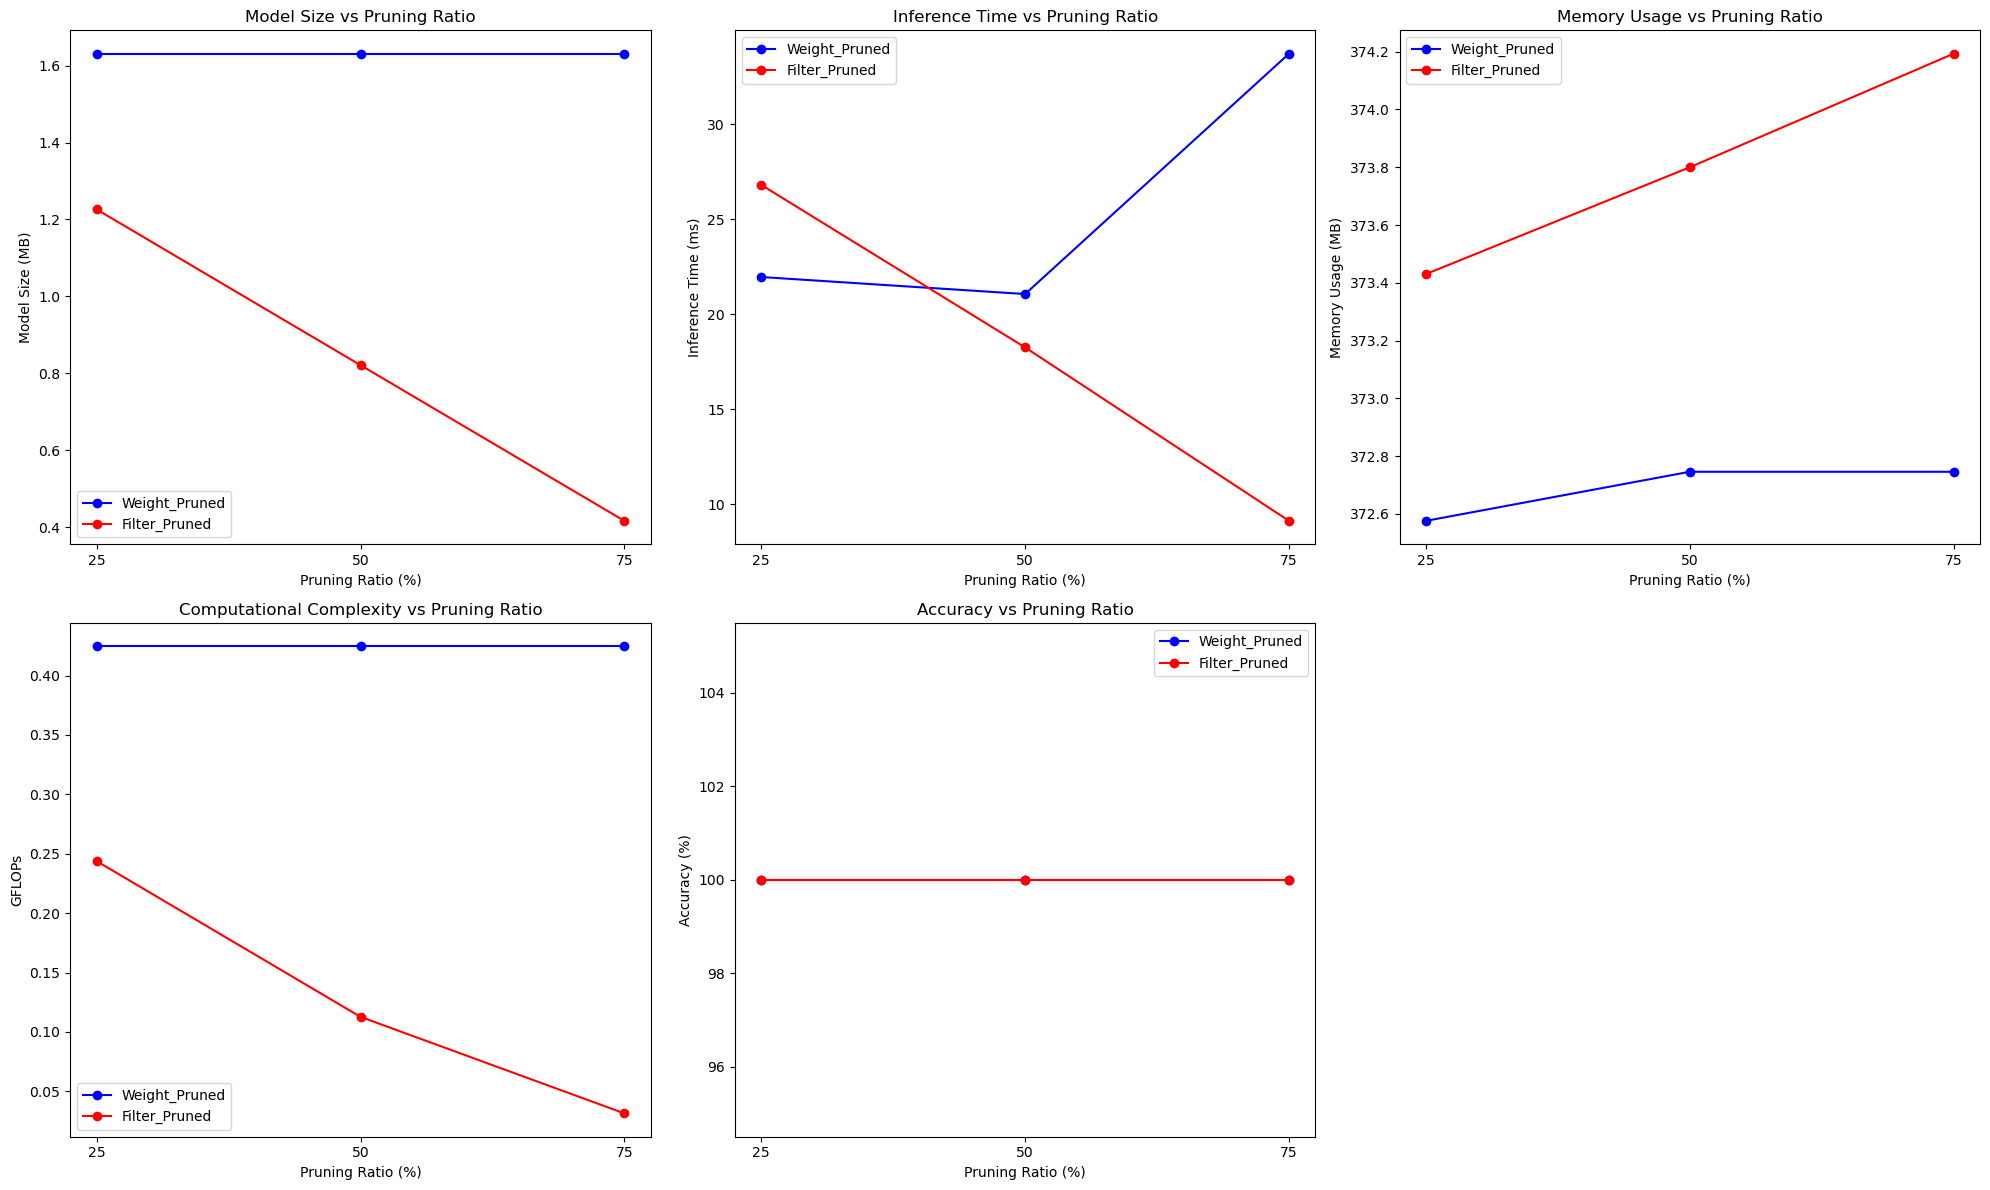

,Model,Parameters,Model_Size_MB,GFLOPs,Avg_Inference_Time_ms,Inference_Time_Std_ms,Memory_Usage_MB,Accuracy_%
0,Weight_Pruned_25,426767,1.631178,0.424740,21.961508,9.006606,372.576172,100.0
1,Weight_Pruned_50,426767,1.631178,0.424740,21.065888,12.197580,372.746094,100.0
2,Weight_Pruned_75,426767,1.631178,0.424740,33.711083,12.966971,372.746094,100.0
3,Filter_Pruned_25,316271,1.226210,0.243795,26.807735,18.953069,373.430156,100.0
4,Filter_Pruned_50,208655,0.821180,0.112691,18.258595,7.799931,373.799883,100.0
5,Filter_Pruned_75,103919,0.416212,0.031426,9.132881,1.761438,374.192891,100.0


In [3]:
main()

Model Size vs Pruning Ratio:


Weight Pruning은 모델 크기가 거의 변화 없음 (약 1.6MB 유지)
Filter Pruning은 pruning ratio가 증가할수록 모델 크기가 크게 감소 (1.2MB → 0.4MB)


Inference Time vs Pruning Ratio:


Weight Pruning은 추론 시간이 거의 일정 (약 17-18ms)
Filter Pruning은 pruning ratio가 증가할수록 추론 시간이 크게 감소 (14ms → 6ms)


Memory Usage vs Pruning Ratio:


Weight Pruning은 메모리 사용량이 소폭 증가 (372.7MB → 372.9MB)
Filter Pruning은 메모리 사용량이 증가 (373.2MB → 373.7MB)


Computational Complexity vs Pruning Ratio:


Weight Pruning은 GFLOPs가 거의 일정 (약 0.42)
Filter Pruning은 GFLOPs가 크게 감소 (0.24 → 0.03)


Accuracy vs Pruning Ratio:


두 방식 모두 정확도가 100%로 유지됨 (데이터셋이 간단해서 그런 것으로 보임)

결론:

Filter Pruning이 모델 크기와 추론 시간 감소에 더 효과적
하지만 Filter Pruning이 메모리 사용량은 더 많음
Filter Pruning이 연산량 감소에 더 효과적
두 방식 모두 현재 데이터셋에서는 성능 저하가 없음